In [266]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

import pandas as pd



np.random.seed(1234)
_ = torch.manual_seed(123)

In [267]:
my_data = pd.read_csv("data_ready_45.csv")

In [268]:
df_train, df_val_test = train_test_split(my_data, test_size=0.3, random_state=654)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=654)

In [269]:
numeric_cols = [
    "CREAT_TRR", "AMIS", "BMIS", "DRMIS", "HLAMIS", "NPKID", "NPPAN", "AGE_DON", "BUN_DON", 
    "CREAT_DON", "SGOT_DON", "SGPT_DON", "TBILI_DON", "BMI_DON_CALC", "AGE", "PA_PRESERV_TM", 
    "DAYSWAIT_CHRON_PA", "BMI_CALC"
    # , "LIPASE", "AMYLASE", "YRS_DIAB"
]

no_scale = ['CMV_STATUS', 'GENDER_DON', 'EBV_SEROSTATUS', 'WGT_KG_DON_CALC', 'VEN_EXT_GRF', 'PT_STEROIDS_DON', 'GENDER', 'MALIG', 'ANTIHYPE_DON', 'MULTIORG', 'DUCT_MGMT_999', 'INOTROP_SUPPORT_DON', 'WGT_KG_CALC', 'TX_TYPE_PTA', 'NON_HRT_DON', 'CMV_DON', 'PULM_INF_CONF_DON', 'TX_TYPE_PWK', 'BLOOD_INF_CONF_DON', 'RESUSCIT_DUR', 'PROTEIN_URINE', 'ART_RECON_is2', 'DUCT_MGMT_1', 'HEPARIN_DON', 'PERIP_VASC', 'VASODIL_DON', 'DDAVP_DON', 'CLIN_INFECT_DON', 'CARDARREST_NEURO', 'DUCT_MGMT_3', 'HGT_CM_DON_CALC', 'DUCT_MGMT_2', 'HIST_HYPERTENS_DON', 'PT_DIURETICS_DON', 'HIST_OTH_DRUG_DON', 'HIST_CIG_DON', 'HIST_CANCER_DON', 'HCV_SEROSTATUS', 'HIST_COCAINE_DON', 'HBV_SUR_ANTIGEN', 'PT_T3_DON', 'PT_T4_DON', 'OTHER_INF_CONF_DON', 'HBV_CORE', 'PA_PRESERV_TM', 'GRF_PLACEM_is1', 'ORGAN_isKP']

# no_scale = ['GENDER', 'PERIP_VASC', 'AGE_DIAB', 'DDAVP_DON', 'CMV_DON', 'GENDER_DON', 'NON_HRT_DON', 'ANTIHYPE_DON', 'BLOOD_INF_CONF_DON', 'OTHER_INF_CONF_DON', 'PT_DIURETICS_DON', 'PT_STEROIDS_DON', 'PT_T3_DON', 'PT_T4_DON', 'PULM_INF_CONF_DON', 'URINE_INF_CONF_DON', 'VASODIL_DON', 'CLIN_INFECT_DON', 'HIST_CIG_DON', 'HIST_COCAINE_DON', 'HIST_HYPERTENS_DON', 'HIST_CANCER_DON', 'HIST_OTH_DRUG_DON', 'HEPARIN_DON', 'HGT_CM_DON_CALC', 'WGT_KG_DON_CALC', 'ABO_MAT', 'DIAL_TRR', 'MULTIORG', 'ART_RECON_is2', 'DUCT_MGMT_1', 'DUCT_MGMT_2', 'DUCT_MGMT_3', 'DUCT_MGMT_999', 'GRF_PLACEM_is1', 'VASC_MGMT_is1', 'VEN_EXT_GRF', 'DIAG_PA_is5001', 'ORGAN_isKP', 'CMV_IGG', 'CMV_IGM', 'EBV_SEROSTATUS', 'HBV_CORE', 'HBV_SUR_ANTIGEN', 'HCV_SEROSTATUS', 'CMV_STATUS', 'TX_TYPE_PTA', 'TX_TYPE_PWK', 'MED_COND_TRR_is3', 'MALIG', 'HGT_CM_CALC', 'WGT_KG_CALC', 'PROTEIN_URINE', 'CARDARREST_NEURO', 'RESUSCIT_DUR', 'INOTROP_SUPPORT_DON']


In [270]:
standardize = [([col], StandardScaler()) for col in numeric_cols]
leave = [(col, None) for col in no_scale]

x_mapper = DataFrameMapper(standardize + leave)

In [271]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [272]:
num_durations = 7135
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['time_frame'].values, df['GRF_STAT_PA'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [273]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [274]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch

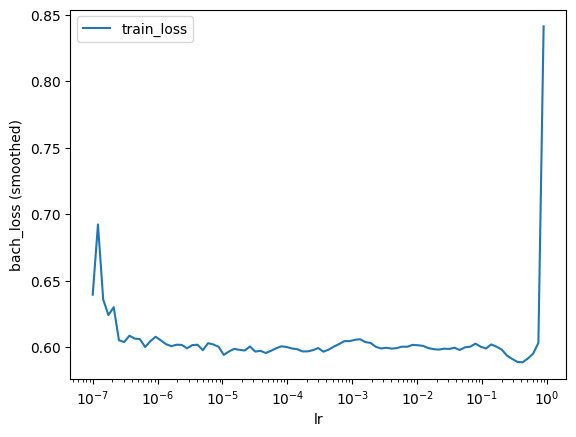

In [275]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [276]:
lr_finder.get_best_lr()

0.04229242874389523

In [277]:
model.optimizer.set_lr(0.0001)

In [278]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[4s / 4s],		train_loss: 0.5996,	val_loss: 0.6347
1:	[4s / 8s],		train_loss: 0.5973,	val_loss: 0.6337
2:	[4s / 12s],		train_loss: 0.5957,	val_loss: 0.6329
3:	[4s / 16s],		train_loss: 0.5938,	val_loss: 0.6320
4:	[4s / 21s],		train_loss: 0.5925,	val_loss: 0.6313
5:	[4s / 25s],		train_loss: 0.5911,	val_loss: 0.6303
6:	[4s / 30s],		train_loss: 0.5892,	val_loss: 0.6298
7:	[4s / 34s],		train_loss: 0.5873,	val_loss: 0.6290
8:	[4s / 38s],		train_loss: 0.5870,	val_loss: 0.6280
9:	[4s / 42s],		train_loss: 0.5853,	val_loss: 0.6275
10:	[4s / 47s],		train_loss: 0.5839,	val_loss: 0.6266
11:	[4s / 51s],		train_loss: 0.5817,	val_loss: 0.6260
12:	[4s / 56s],		train_loss: 0.5805,	val_loss: 0.6253
13:	[4s / 1m:0s],		train_loss: 0.5791,	val_loss: 0.6247
14:	[4s / 1m:4s],		train_loss: 0.5776,	val_loss: 0.6238
15:	[4s / 1m:8s],		train_loss: 0.5761,	val_loss: 0.6232
16:	[4s / 1m:13s],		train_loss: 0.5752,	val_loss: 0.6226
17:	[4s / 1m:17s],		train_loss: 0.5732,	val_loss: 0.6219
18:	[4s / 1m:21s],		train_lo

c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch

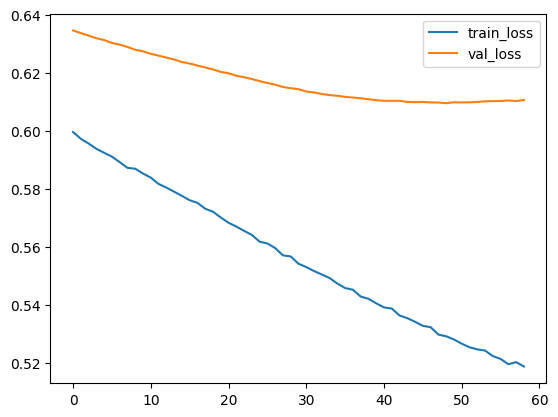

In [279]:
_ = log.plot()

In [280]:
surv = model.predict_surv_df(x_test)

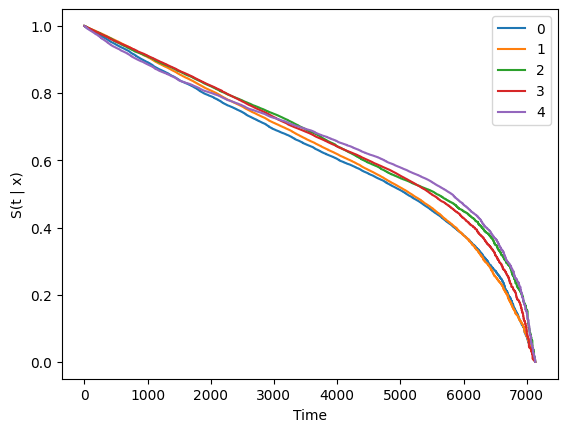

In [281]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [282]:
surv = model.interpolate(10).predict_surv_df(x_test)

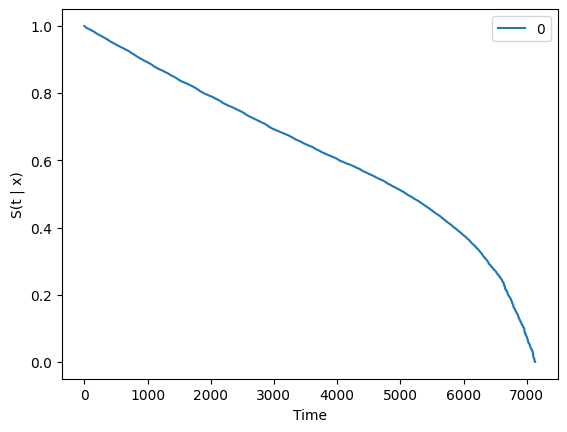

In [283]:
surv.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [284]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [285]:
ev.concordance_td('antolini')

0.6554853400883907

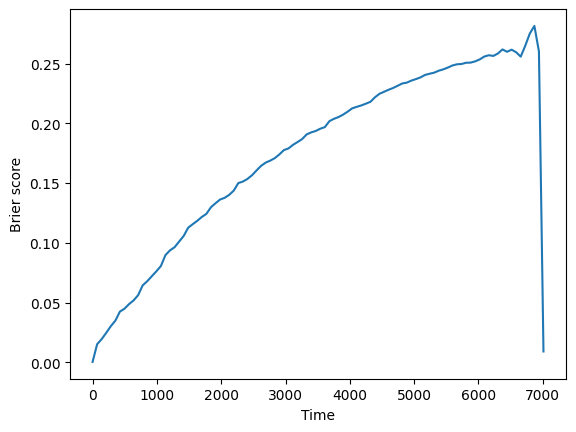

In [286]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

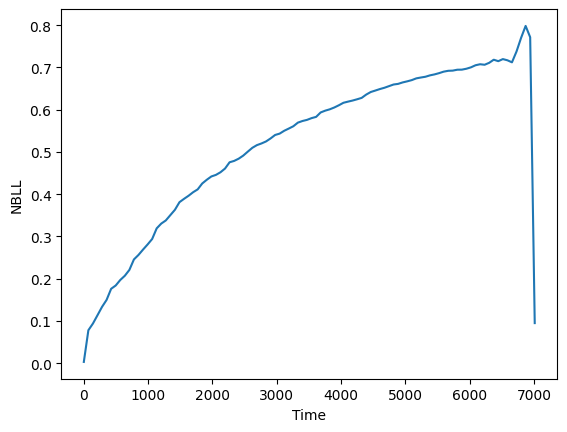

In [287]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [288]:
ev.integrated_brier_score(time_grid) 

0.17594731864394175

In [289]:
times = np.arange(30, 365*19, 365)

surv_probs = model.predict_surv_df(x_test)

surv_probs = surv_probs.T

time_bins = surv_probs.columns  # Get the time bins from the survival probabilities DataFrame
closest_bin_indices = [np.abs(time_bins - tp).argmin() for tp in times]

# Extract the survival probabilities (or risk scores) at those specific time points
selected_surv_probs = surv_probs.iloc[:, closest_bin_indices]
selected_risk_scores = 1 - selected_surv_probs 

In [290]:
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv

y_test = pd.DataFrame({
                    "GRF_STAT_PA" : events_test,
                    "time_frame" : durations_test
})


y_train = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=df_train)
y_test = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_test)

auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, selected_risk_scores, times)

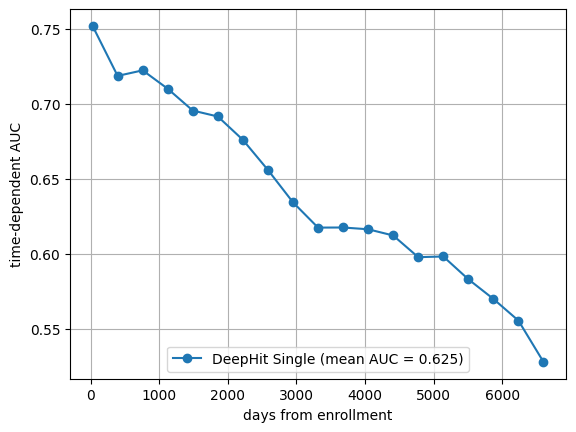

In [291]:
plt.plot(times, auc, "o-", label=f"DeepHit Single (mean AUC = {mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)